# Evaluating Sharpness Preservation

Get 10% and 50% MTFs for fbp, red-cnn, and red-cnn augmentation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CCT189_peds'
phantom_meta = pd.read_csv(phantom_dir / 'metadata.csv')
phantom_meta

,Name,effective diameter (cm),FOV (cm),recon,phantom,simulated,file,Dose [%]
0,35.0 cm MITA-LCD,35.0,39,RED-CNN augmented,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
1,35.0 cm MITA-LCD,35.0,39,RED-CNN,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
2,35.0 cm MITA-LCD,35.0,39,fbp,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
3,35.0 cm MITA-LCD,35.0,39,RED-CNN augmented,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,40
4,35.0 cm MITA-LCD,35.0,39,RED-CNN,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,40
...,...,...,...,...,...,...,...,...
373,15.1 cm uniform,15.1,17,RED-CNN,uniform,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,70
374,15.1 cm uniform,15.1,17,fbp,uniform,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,70
375,15.1 cm uniform,15.1,17,RED-CNN augmented,uniform,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,85
376,15.1 cm uniform,15.1,17,RED-CNN,uniform,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,85


In [3]:
phantom_meta.file[0]

'/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/diameter350mm/signal_present/dose_010/RED-CNN augmented/signal_present.mhd'

Desired directory structure

```directory
phantom /
        / diameter /
                   / dose /
                          / recon
```

1. move the CTP404 phantom simulations from `/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404` to `/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds` - done
2. add metaheaders to make them easier to load, with pixel size and recon info? -> dicom eventually for this last one - done
3. make metadata csv like for CCT189 - done 
4. make sure Ct numbers have 0 offset, so air == -1000, water == 0 - done
5. then run /home/brandon.nelson/Dev/DLIR_Ped_Generalizability/geometric_phantom_studies/evaluation/MTF

In [4]:
src_dir = Path('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404')
dst_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds')

In [5]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter112mm/dose_010/fbp/

112mm_dose_010_fbp.mhd	112mm_dose_010_fbp.raw


In [6]:
# !rm -rf /gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404

from shutil import copyfile
from tqdm import tqdm

raw_files = list(src_dir.rglob('*.raw'))

max_dose = 300000

write = True

name = []
diameters = []
fovs = []
doses = []
recons = []
files = []
phantom = 'CTP404'
kernel = 'D45'

for file in tqdm(raw_files):
    if file.stem == 'true':
        _, diameter, fname = file.relative_to(src_dir).parts
        outfile = dst_dir / diameter / fname
        outfile = Path(str(outfile).replace('.raw', '.mhd'))

        geom = pd.read_csv(file.parent /'geometry_info.csv', index_col=0).T
        info = pd.read_csv(file.parent /'image_info.csv', index_col=0).T
        offset = int(info.index[0])
        nx = int(geom['ny'].item())
        array = np.fromfile(file, dtype='int16').reshape((nx, nx)) - offset
        img = sitk.GetImageFromArray(array)
        img.SetSpacing(2*[float(geom['dx'].item())])
        if write:
            outfile.parent.mkdir(exist_ok=True, parents=True)
            sitk.WriteImage(img, outfile)

    else:
        _, diameter, dose, recon, fname = file.relative_to(src_dir).parts

        if dose.endswith('processed'):
            continue

        recon = recon.removesuffix('_sharp')
        dose = f"dose_{round(int(dose.split('_')[1])/max_dose*100):03d}"
        outfile = dst_dir / diameter / dose / recon / f"{diameter.removeprefix('diameter')}_{dose}_{recon}_{int(fname.split('v')[1].split('.raw')[0]):03d}.mhd"

        geom = pd.read_csv(file.parents[2] /'geometry_info.csv', index_col=0).T
        info = pd.read_csv(file.parents[2] /'image_info.csv', index_col=0).T
        offset = int(info.index[0])
        nx = int(geom['ny'].item())
        array = np.fromfile(file, dtype='int16').reshape((nx, nx)) - offset
        img = sitk.GetImageFromArray(array)
        img.SetSpacing(2*[float(geom['dx'].item())])
        if write:
            outfile.parent.mkdir(exist_ok=True, parents=True)
            sitk.WriteImage(img, outfile)
        

        name.append(f"{float(diameter.split('diameter')[1].split('mm')[0])/10} cm {phantom}")
        diameters.append(float(diameter.split('diameter')[1].split('mm')[0])/10)
        fovs.append(round(img.GetSpacing()[0]*nx)/10)
        doses.append(int(dose.split('_')[1]))
        recons.append(recon)
        files.append(outfile.relative_to(dst_dir))

pd.DataFrame({
    'name': name,
    'phantom': len(files)*[phantom],
    'effective diameter [cm]': diameters,
    'FOV [cm]': fovs,
    'Dose [%]': doses,
    'recon': recons,
    'kernel': len(files)*[kernel],
    'file': files}).to_csv(dst_dir/'metadata.csv',index=False)

In [7]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_040/fbp

350mm_dose_040_fbp.mhd	350mm_dose_040_fbp.raw


In [9]:
import SimpleITK as sitk
vol = sitk.ReadImage('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter112mm/dose_010/fbp/112mm_dose_010_fbp.mhd')
vol.GetDepth(), vol.GetWidth(), vol.GetHeight()

(20, 512, 512)

In [10]:
meta = pd.read_csv(dst_dir/'metadata.csv')
meta.file[0]

'/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_025/fbp/350mm_dose_025_fbp.mhd'

Like before load up all the files, sort into volumes and resave into one mhd and update metafile

from os import remove
import SimpleITK as sitk

name = []
diameters = []
fovs = []
doses = []
recons = []
files = []
phantom = 'CTP404'
kernel = 'D45'

for diameter in meta['effective diameter [cm]'].unique():
    temp = meta[(meta['effective diameter [cm]'] == diameter)].copy()
    for dose in temp['Dose [%]'].unique():
        vol = []
        for file in temp[temp['Dose [%]']==dose].file:
            file = Path(file)
            for tempfile in file.parent.glob('*'):
                if len(tempfile.stem.split('_')) == 4:
                    print(tempfile, ' keep')
                else:
                    print(tempfile, ' delete')
                    remove(tempfile)
    #         break
    #     break
    # break
    
                # file = Path(file)
                # tempfile = file.parent / (file.stem + f'_fbp_{i+1:03d}.mhd')
            # # if not file.exists(): continue
            #     img = sitk.ReadImage(tempfile)
            #     vol.append(sitk.GetArrayFromImage(img))
            # file = tempfile
        # if not vol: continue
        # vol = np.stack(vol)
        # vol = sitk.GetImageFromArray(vol)
        # vol.SetSpacing(vol.GetDimension()*[img.GetSpacing()[0]])
        # outfile = file.parent / ('_'.join(file.stem.split('_')[:-1])+file.suffix)
        # break
        # remove(str(file))
        # remove(str(file).replace('.mhd', '.raw'))
        # name.append(temp[temp['Dose [%]']==dose]['name'].iloc[0])
        # diameters.append(diameter)
        # fovs.append(temp[temp['Dose [%]']==dose].iloc[0]['FOV [cm]'])
        # doses.append(dose)
        # recons.append(temp[temp['Dose [%]']==dose].iloc[0]['recon'])
        # files.append(outfile)
        # sitk.WriteImage(vol, outfile)
        # print(outfile)

# meta = pd.DataFrame({
#     'name': name,
#     'phantom': len(files)*[phantom],
#     'effective diameter [cm]': diameters,
#     'FOV [cm]': fovs,
#     'Dose [%]': doses,
#     'recon': recons,
#     'kernel': len(files)*[kernel],
#     'file': files})
# meta.to_csv(dst_dir/'metadata.csv',index=False)

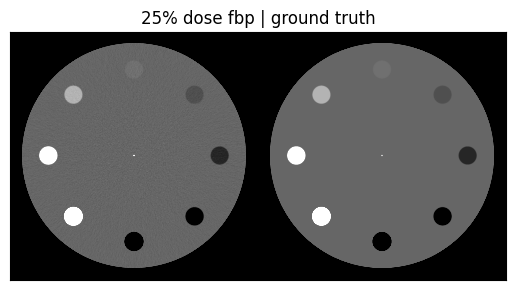

In [11]:
from results_utils import browse_studies, study_viewer
browse_studies(meta, phantom='CTP404', diameter=35, fov=38.5, dose=25, recon='fbp')

In [12]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404',), value='CTP404'), Dropdown(descripti…